In [554]:
# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
# Feature Engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Machine Learning
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from lazypredict.Supervised import LazyClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear, sigmoid
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Planetary Computer Tools
import pystac
import pystac_client
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import odc
import toolz
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('8e9b6659b924459a988554b473a6a8e7')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()


#Get vh_vv function

def get_sentinel_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    
    box_size_deg = 0.0009 # Surrounding box in degrees, yields approximately 5x5 pixel region

    min_lon = float(latlong[1])-box_size_deg/2
    min_lat = float(latlong[0])-box_size_deg/2
    max_lon = float(latlong[1])+box_size_deg/2
    max_lat = float(latlong[0])+box_size_deg/2

    bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)
    #bbox_of_interest = (float(latlong[1]) , float(latlong[0]), float(latlong[1]) , float(latlong[0]))
    
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=pc.sign_inplace,
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
    )
    items = list(search.get_all_items())
    
    
    
    # Define the pixel resolution for the final product
    # Define the scale according to our selected crs, so we will use degrees

    resolution = 10  # meters per pixel 
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 
    
    # Load the data using Open Data Cube
    data = stac_load(items,bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:4326", resolution=scale)
   
    # Calculate the mean of the data across the sample region
    mean = data.mean(dim=['latitude','longitude']).compute()
    
    # Calculate V
    v = mean.vv + mean.vh
    
    
    return v.values

def get_new_features(data,L):
    #data = 600 time series list of values
    
    
    new_features=[]
    if 'mean' in L:
        the_means=[]
        for col in data.columns:
            mean_v = float(np.mean(data[col]))
            the_means.append(mean_v)
        new_features.append(the_means)
    
    if 'std' in L:
        the_stds=[]
        for col in data.columns:
            sigma_v = float(np.std(data[col]))
            the_stds.append(sigma_v)
        new_features.append(the_stds)
    
    if 'CV' in L:
        the_CVs=[]
        for col in data.columns:
            mean_v = float(np.mean(data[col]))
            sigma_v = float(np.std(data[col]))
            CV_v = float(mean_v/sigma_v)
            the_CVs.append(CV_v)
        new_features.append(the_CVs)
    
    if 'max' in L:
        the_maxs=[]
        for col in data.columns:
            max_v = float(max(data[col]))
            the_maxs.append(max_v)
        new_features.append(the_maxs)
        
    if 'min' in L:
        the_mins=[]
        for col in data.columns:
            min_v = float(min(data[col]))
            the_mins.append(min_v)
        new_features.append(the_mins)
        
    if 'median' in L:
        the_medians=[]
        for col in data.columns:
            median_v = float(np.median(data[col]))
            the_medians.append(median_v)
        new_features.append(the_medians)
    
    if 'amplitude' in L:
        the_amplis=[]
        for col in data.columns:
            max_v = float(max(data[col]))
            min_v = float(min(data[col]))
            ampli_v = abs(max_v-min_v)
            the_amplis.append(ampli_v)
        new_features.append(the_amplis)
        
    if 'absolute energy' in L:
        the_abs_Es=[]
        for col in data.columns:
            abs_E_v = float(sum((data[col])**2))
            the_abs_Es.append(abs_E_v)
        new_features.append(the_abs_Es)
    
    if 'mean diff' in L:
        the_mean_diffs=[]
        col_1 = np.delete(data[col].values,0)
        col_2 = np.delete(data[col].values,len(data[col])-1)
        delta_v = col_1-col_2
        for col in data.columns:
            mean_delta_v = float(np.mean(delta_v))
            the_mean_diffs.append(mean_delta_v)
        new_features.append(the_mean_diffs)
        
    if 'autocorrelation lag 1' in L:
        the_auto_lag_1s=[]
        for col in data.columns: 
            the_auto=sm.tsa.acf(data[col])[1]
            the_auto_lag_1s.append(the_auto)
        new_features.append(the_auto_lag_1s)
    
    #median_delta_v = float(np.median(delta_v))
    #sum_delta_v = float(sum(abs(delta_v)))
    #dist_v = float(sum(np.sqrt(1+delta_v**2)))#signal distance 
    
    return np.transpose(pd.DataFrame(new_features))
        
        
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);
    
if __name__ == "__main__":
    
    crop_presence_data = pd.read_csv("Crop_Location_Data.csv")
    crop_presence_data.head()
    
    

In [ ]:
 # Function call to extract VV,VH Values
time_slice = "2019-01-01/2020-12-31"
assests = ['vh','vv']
list_v = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    v=get_sentinel_data(coordinates,time_slice,assests)
    list_v.append(v)
list_v = np.transpose(pd.DataFrame(list_v))

In [555]:
#list_v.to_csv('list_vh+vv_mean10x10.csv_2years', index=False)
list_v = pd.read_csv('list_vh+vv_mean10x10.csv')


In [109]:
#list_v=list_v.drop(index=list_v.index[181:])
#list_v=list_v.drop(labels=['Unnamed: 0'], axis=1)

In [ ]:
list_v

In [556]:
list_vf=get_new_features(list_v,['mean','std','absolute energy','median','amplitude','max','min','CV'])

In [557]:
#anomaly detection

to_drop=[]
for i in range(np.shape(list_vf)[0]):
    for j in range(np.shape(list_vf)[1]):
        if abs(list_vf[j][i])>=65 or list_vf[j][i]==bool(float('nan')):
            to_drop.append(i)
list_vf=list_vf.drop(index=list_vf.index[to_drop])
crop_presence_data=crop_presence_data.drop(index=crop_presence_data.index[to_drop])
list_vf=list_vf.reset_index(drop=True)
crop_presence_data=crop_presence_data.reset_index(drop=True)

In [558]:
pd.set_option('display.max_rows', 10)
list_vf

,0,1,2,3,4,5,6,7
0,0.15,0.08,1.85,0.42,0.03,0.14,0.38,2.66
1,0.16,0.09,1.72,0.40,0.02,0.14,0.38,3.17
2,0.17,0.09,1.91,0.42,0.02,0.16,0.40,3.54
3,0.15,0.08,1.82,0.37,0.02,0.14,0.35,2.71
4,0.17,0.10,1.69,0.47,0.03,0.14,0.44,3.62
...,...,...,...,...,...,...,...,...
573,0.36,0.05,6.67,0.46,0.24,0.37,0.22,11.93
574,0.39,0.05,7.14,0.50,0.25,0.40,0.25,14.01
575,0.39,0.05,7.43,0.52,0.26,0.39,0.26,13.77
576,0.38,0.05,7.76,0.52,0.29,0.37,0.23,13.28


In [ ]:
#list_vf[].plot()

In [85]:
#list_vf=list_vf.drop(labels=[7], axis=1)

In [559]:
#Combine Latitude, Longitude and VV/VH
crop_data = combine_two_datasets(crop_presence_data,list_vf)

In [560]:
crop_data

,Latitude and Longitude,Class of Land,0,1,2,3,4,5,6,7
0,"(10.323727047081501, 105.2516346045924)",Rice,0.15,0.08,1.85,0.42,0.03,0.14,0.38,2.66
1,"(10.322364360592521, 105.27843410554115)",Rice,0.16,0.09,1.72,0.40,0.02,0.14,0.38,3.17
2,"(10.321455902933202, 105.25254306225168)",Rice,0.17,0.09,1.91,0.42,0.02,0.16,0.40,3.54
3,"(10.324181275911162, 105.25118037576274)",Rice,0.15,0.08,1.82,0.37,0.02,0.14,0.35,2.71
4,"(10.324635504740822, 105.27389181724476)",Rice,0.17,0.10,1.69,0.47,0.03,0.14,0.44,3.62
...,...,...,...,...,...,...,...,...,...,...
573,"(10.013942985253381, 105.67361318732796)",Non Rice,0.36,0.05,6.67,0.46,0.24,0.37,0.22,11.93
574,"(10.01348875642372, 105.67361318732796)",Non Rice,0.39,0.05,7.14,0.50,0.25,0.40,0.25,14.01
575,"(10.013034527594062, 105.67361318732796)",Non Rice,0.39,0.05,7.43,0.52,0.26,0.39,0.26,13.77
576,"(10.012580298764401, 105.67361318732796)",Non Rice,0.38,0.05,7.76,0.52,0.29,0.37,0.23,13.28


In [561]:
crop_data['Class of Land'].loc[crop_data['Class of Land']=="Rice"]=1.0
crop_data['Class of Land'].loc[crop_data['Class of Land']=="Non Rice"]=0.0

In [562]:
#Model building
#crop_data = crop_data[['vh','vv','Class of Land']]
X = crop_data.drop(columns=['Class of Land','Latitude and Longitude']).values
y = crop_data ['Class of Land'].values
y = np.asarray(y).astype("float64")
X = np.asarray(X).astype("float64")
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=40)



In [563]:
#Feature scaling 1
sc = StandardScaler()
X = sc.fit_transform(X)
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [564]:
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape,"y_train.shape:", y_train.shape, "X_cv.shape:", X_cv.shape, "y_cv.shape:", y_cv.shape, "X_test.shape:", X_test.shape,"y_test.shape:", y_test.shape)
    #Out sample evaluation
#model=models.axes[0][0]
#outsample_predictions = model.predict(X_test)
#print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
    #print(classification_report(y_test, outsample_predictions))
    #plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Logistic\nRegression Model Out-Sample Results",['Rice', 'Non Rice'])
    

X_train.shape: (346, 8) y_train.shape: (346,) X_cv.shape: (185, 8) y_cv.shape: (185,) X_test.shape: (47, 8) y_test.shape: (47,)


In [369]:
#y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
#y_cv = np.asarray(y_cv).astype('float32').reshape((-1,1))
#y_test = np.asarray(y_test).astype('float32').reshape((-1,1))


In [681]:
#Neural Network
#tf.random.set_seed(1234)
lamb=0.14
model = Sequential(
    [
        Dense(units=5, input_shape=(X.shape[1],), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lamb)),
        Dense(units=5, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(lamb)),
        #Dense(units=5, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(lamb)),
        #Dense(units=6, activation='relu'),
        Dense(units=2, activation='linear')


    ], name="NN"
)

#model.summary() 

model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
    
)


In [682]:

model.fit(
    X_train, y_train,
    epochs=100, batch_size=35, verbose=0
)


In [683]:
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)

In [684]:
training_cerr_complex = f1_score(y_train, model_predict(X_train))
cv_cerr_complex = f1_score(y_cv, model_predict(X_cv))
test_cerr_complex = f1_score(y_test, model_predict(X_test))
print(f"f1_score,training: {training_cerr_complex:0.3f}")
print(f"f1_score,cv: {cv_cerr_complex:0.3f}")
print(f"f1_score,test: {test_cerr_complex:0.3f}")

2/2 [==============================] - 0s 2ms/step
f1_score,training: 1.000
f1_score,cv: 1.000
f1_score,test: 1.000


In [ ]:
#Out sample evaluation

#estimator = KerasClassifier(model=model, epochs=20, batch_size=5,verbose=0)
#kfold = StratifiedKFold(n_splits=10, shuffle=True)
#results = cross_val_score(estimator, X, y, cv=kfold, scoring='f1')
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


In [569]:
#Submission test 
test_file = pd.read_csv('challenge_1_submission_template_correct_columns_fixed.csv')
test_file

,id,target
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN
3,"(10.583364246115156, 105.23946127195805)",NaN
4,"(10.20744446668854, 105.26844107128906)",NaN
...,...,...
245,"(10.308283266873062, 105.50872812216863)",NaN
246,"(10.582910017285496, 105.23991550078767)",NaN
247,"(10.581547330796518, 105.23991550078767)",NaN
248,"(10.629241357910818, 105.15315779432643)",NaN


In [ ]:
    
## Get Sentinel-1-RTC Data
time_slice = "2020-01-01/2020-12-31"
assests = ['vh','vv']
list_vs = []
for coordinates in tqdm(test_file['id']):
    vs=get_sentinel_data(coordinates,time_slice,assests)
    list_vs.append(vs)
submission_v_data = np.transpose(pd.DataFrame(list_vs))


In [685]:
#submission_v_data.to_csv('submission_vh+vv_ampli_mean10x10.csv', index=False)
submission_v_data= pd.read_csv('submission_vh+vv_ampli_mean10x10.csv')

In [631]:
submission_v_data_f=get_new_features(submission_v_data,['mean','std','absolute energy','median','amplitude','max','min','CV'])

In [98]:
#submission_v_data_f=submission_v_data_f.drop(labels=[7], axis=1)

<AxesSubplot:>

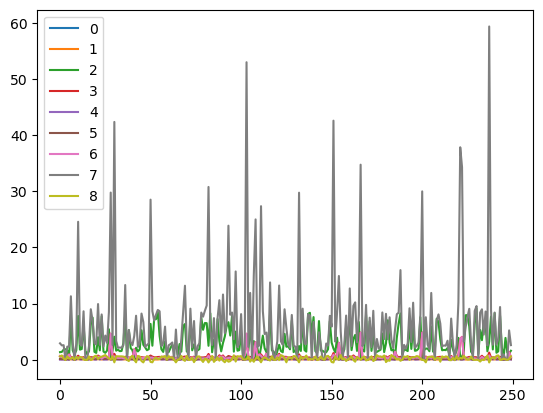

In [467]:
#submission_v_data_f.plot()

In [686]:
# Feature Scaling 
submission_v_data_f #= submission_vh_vv_data.values
transformed_submission_data = sc.transform(submission_v_data_f)

#Making predictions
final_predictions = model_predict(transformed_submission_data)
final_prediction_logits= np.transpose(tf.round(final_predictions))
final_prediction_series = pd.Series(final_prediction_logits)
final_prediction_series.loc[final_prediction_series==0.]='Non Rice'
final_prediction_series.loc[final_prediction_series==1.]='Rice'

#Combining the results into dataframe
submission_df = pd.DataFrame({'id':test_file['id'].values, 'target':final_prediction_series.values})
#Displaying the sample submission dataframe
display(submission_df)


8/8 [==============================] - 0s 1ms/step


,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [687]:
#Submission file
#Dumping the predictions into a csv file.
submission_df.to_csv("challenge_1_submission_rice_crop_prediction.csv",index = False)